## Final Project
##### Author: Jiawei Zou (jzou43@wisc.edu)
##### Time: Dec 21st,2023
##### The competition link in Kaggle: https://www.kaggle.com/competitions/autoam-car-price-prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

### 1. Load the dataset and observe the characteristics of the data

In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv').drop("Id",axis=1)

In [3]:
train_data

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000
...,...,...,...,...,...,...,...,...,...,...
1637,hyundai,2017,petrol,120000 miles,left,white,sedan,good,2.0,12400
1638,toyota,2014,petrol,170000 km,left,black,sedan,good,2.0,16500
1639,nissan,2018,petrol,68900 miles,left,blue,suv,good,2.0,19500
1640,nissan,2019,petrol,31000 miles,left,black,suv,excellent,2.0,19500


In [4]:
test_data

,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0
3,kia,2018,petrol,53000 miles,left,silver,sedan,excellent,2.0
4,mercedes-benz,2003,petrol,230000 km,left,black,Universal,normal,1.8
...,...,...,...,...,...,...,...,...,...
406,nissan,2021,petrol,33400 km,left,black,suv,excellent,2.0
407,hyundai,2017,petrol,60000 miles,left,other,sedan,excellent,2.0
408,mercedes-benz,2012,petrol,218000 km,left,white,sedan,good,2.0
409,kia,2020,petrol,40000 miles,left,red,sedan,good,2.0


### 2. Data Cleaning and prepare for analysis

#### 2.1 Convert "running" column to numercial, and unify the column to the same unit. 

In [5]:
train_data['running_numeric'] = train_data['running'].str.extract('(\d+)').astype(float)

In [6]:
def convert_to_km(value):
    numeric_value, unit = value.split()
    numeric_value = float(numeric_value)
    if unit.lower() == 'miles':
        return numeric_value * 1.60934
    elif unit.lower() == 'km':
        return numeric_value
    else:
        return None 
    
train_data['running_numeric'] = train_data['running'].apply(convert_to_km)

In [7]:
train_data.drop('running',axis=1,inplace=True) # Drop the "running" column to aviod confusion. 

In [8]:
train_data['running_numeric'] = train_data['running_numeric'].astype('int64')
train_data['motor_volume'] = train_data['motor_volume'].astype('int64')

In [9]:
# List all the categorical columns and numercial columns for analysis
categorical_column = train_data.select_dtypes(include=['object']).columns.tolist()
numercial_column = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns = {(numercial_column)}, \n\nCategorical columns = {(categorical_column)}")

Numerical columns = ['year', 'motor_volume', 'price', 'running_numeric'], 

Categorical columns = ['model', 'motor_type', 'wheel', 'color', 'type', 'status']


#### 2.2 Outliers analysis

<function matplotlib.pyplot.xticks(ticks=None, labels=None, *, minor=False, **kwargs)>

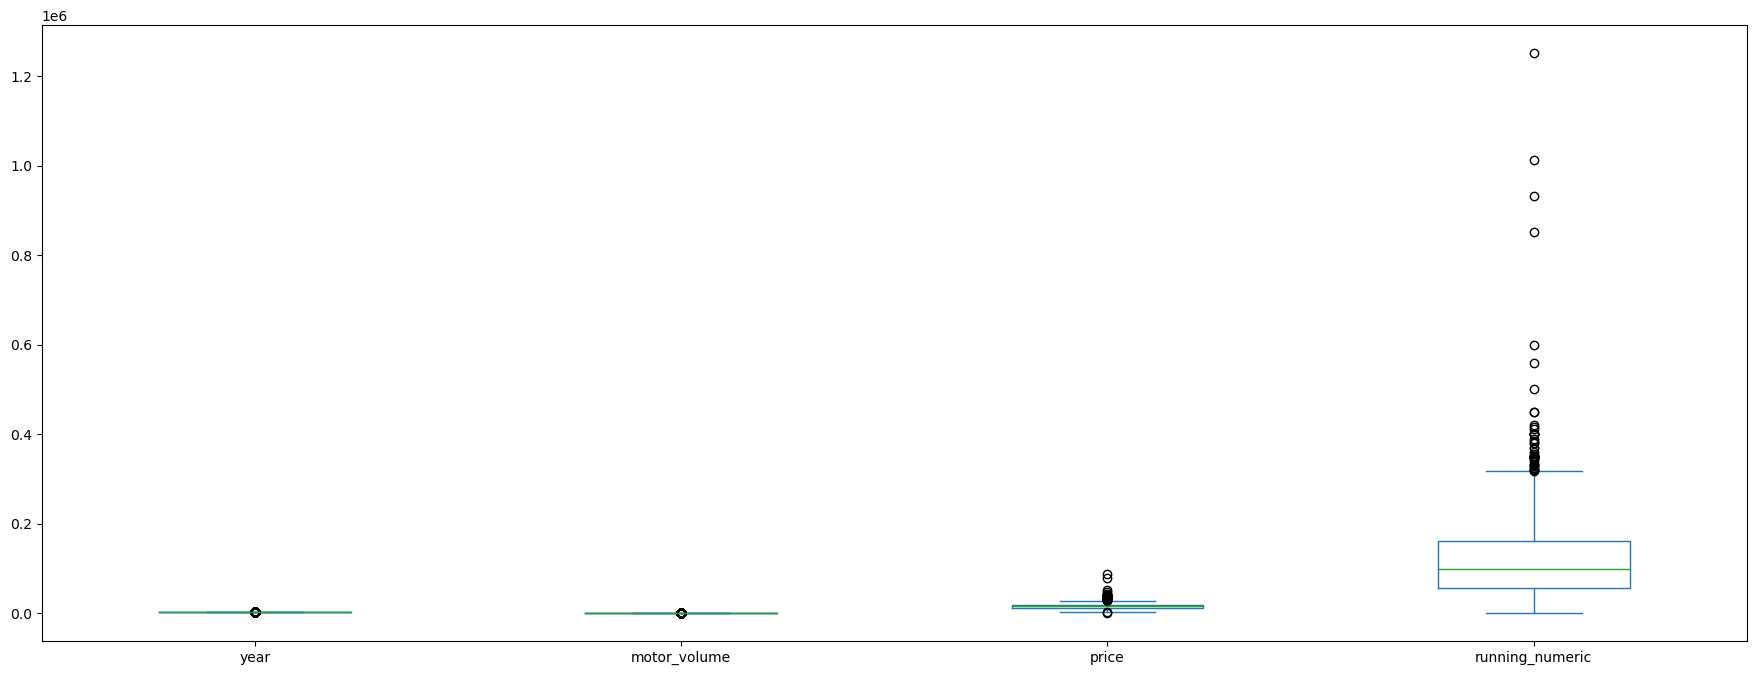

In [10]:
# plot the box plot to identify the outliers
train_data[numercial_column].plot.box(figsize=(22, 8))
plt.xticks

In [11]:
# Define the outlier identification ethod
def out_selection(value):
    Q1 = value.quantile(0.25)
    Q3 = value.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    print(f"upper bound: {upper_bound}, lower bound: {lower_bound}")
    
    return upper_bound, lower_bound

In [12]:
upper_bound_running_numeric, lower_bound_running_numeric = out_selection(train_data.running_numeric)

upper bound: 317795.375, lower bound: -100555.625


In [13]:
# Select out the proper data for future analysis
train_data = train_data[(train_data['running_numeric']< upper_bound_running_numeric) & (train_data['running_numeric']> lower_bound_running_numeric) ]

<function matplotlib.pyplot.xticks(ticks=None, labels=None, *, minor=False, **kwargs)>

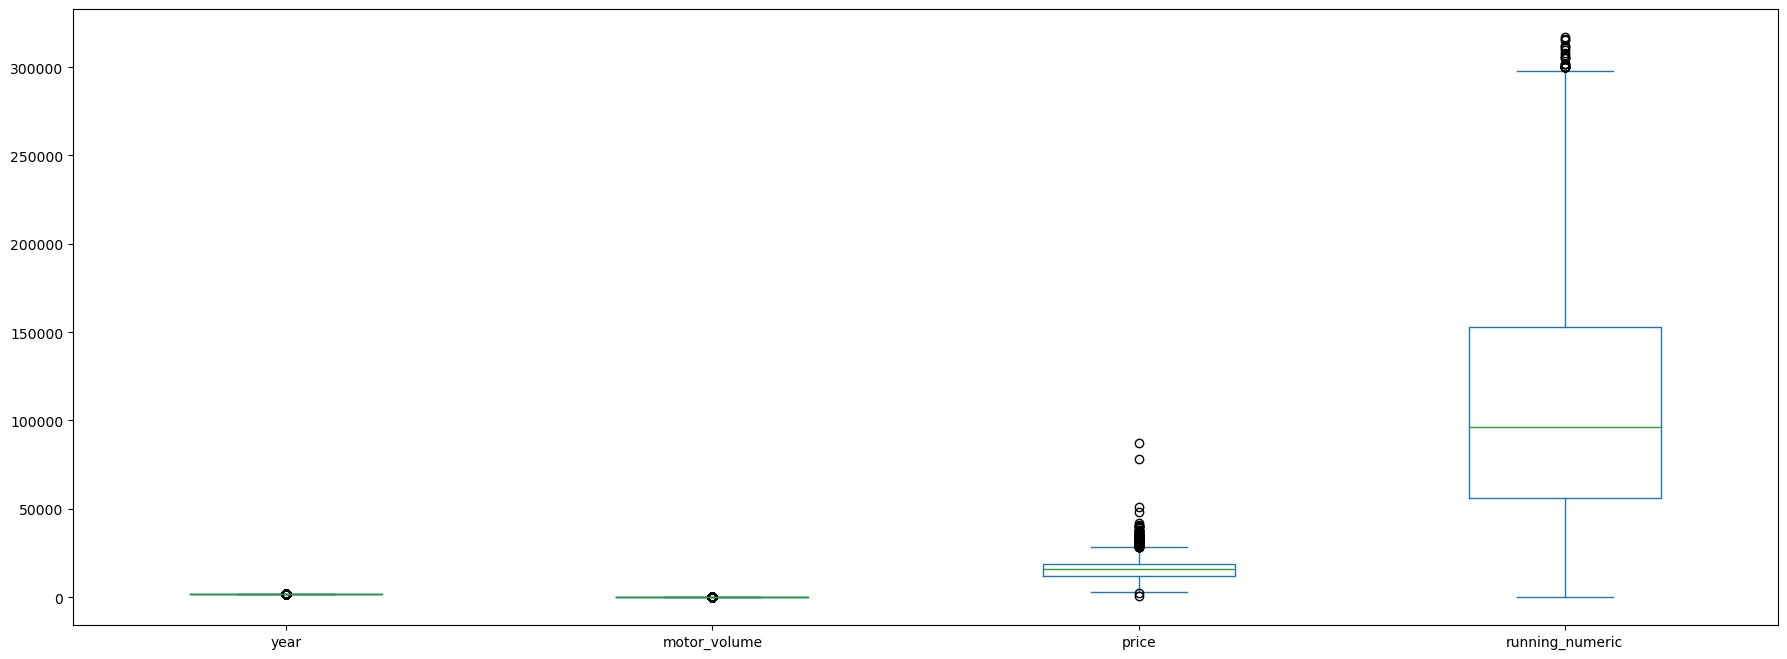

In [14]:
# Plot out the box plot to check again the effect of last step
train_data[numercial_column].plot.box(figsize=(22, 8))
plt.xticks

#### 2.3 Use One Hot Encoder to encode the categorical columns (Make categorical columns contribute to the model prediction, all-rounded model)

In [15]:
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(train_data[categorical_column])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_column))
train_data = train_data.drop(columns=categorical_column)
train_data = pd.concat([train_data, encoded_features_df], axis=1)

/Users/jiaweizou/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
train_data = train_data.dropna()
train_data['wheel_right']=0
train_data 

,year,motor_volume,price,running_numeric,model_hyundai,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_diesel,...,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal,wheel_right
0,2022.0,2.0,24500.0,3000.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,2014.0,2.0,25500.0,132000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,2018.0,2.0,11700.0,152887.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,2002.0,3.0,12000.0,220479.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,2017.0,2.0,26000.0,130000.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,2016.0,2.0,15300.0,85000.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1592,2018.0,2.0,14900.0,133575.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1593,2016.0,2.0,16500.0,115000.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
1594,2020.0,1.0,18500.0,67500.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0


In [17]:
train_data.to_csv('train_data.csv',index=False)

#### 2.4 NaN value analysis

In [18]:
# Get the percent of NaN value in each column, and opt out the high_percentage (NaN) one. 
null_col = pd.DataFrame((train_data.isnull().sum()/train_data.shape[0])*100)
null_col = null_col[null_col[0]>0].reset_index().sort_values(by=0, ascending=False)
null_col = null_col.rename(columns={0: "Percentage of NaN"})
null_col['type'] = ["categorical" if x in categorical_column else "numeric" for x in null_col['index']]

In [19]:
null_col

,index,Percentage of NaN,type


In [20]:
train_data.isnull()

,year,motor_volume,price,running_numeric,model_hyundai,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_diesel,...,type_minivan / minibus,type_pickup,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal,wheel_right
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1592,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1593,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1594,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [21]:
## Here, I find that there is no column to drop as all the columns in this dataset have values, if not, I can use this: 
#  columns_to_drop = ['Column1', 'Column2', 'Column3'] 
# train_data.drop(columns=columns_to_drop, inplace = True)

## And I can also fill the undroped but high-NaN-percentage columns with values, such as: (fill the categorical ones with mode of the columns, and numercial ones with mean of that column)
#  for i in null_col:
#    if (train_data[i].dtype == "int64" or train_data[i].dtype == "float64"):
#        train_data[i].fillna(train_data[i].mean(), inplace=True)
#    elif train_data[i].dtype == "object":
#        train_data[i].fillna(train_data[i].mode()[0], inplace=True)

#### 2.5 Visualize the data

<Axes: >

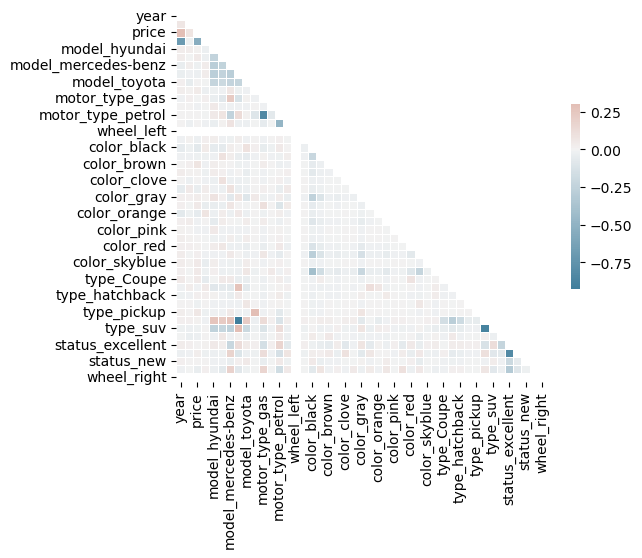

In [22]:
numeric_cols = train_data.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'motor_volume'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'running_numeric'}>,
        <Axes: title={'center': 'model_hyundai'}>,
        <Axes: title={'center': 'model_kia'}>,
        <Axes: title={'center': 'model_mercedes-benz'}>],
       [<Axes: title={'center': 'model_nissan'}>,
        <Axes: title={'center': 'model_toyota'}>,
        <Axes: title={'center': 'motor_type_diesel'}>,
        <Axes: title={'center': 'motor_type_gas'}>,
        <Axes: title={'center': 'motor_type_hybrid'}>,
        <Axes: title={'center': 'motor_type_petrol'}>,
        <Axes: title={'center': 'motor_type_petrol and gas'}>],
       [<Axes: title={'center': 'wheel_left'}>,
        <Axes: title={'center': 'color_beige'}>,
        <Axes: title={'center': 'color_black'}>,
        <Axes: title={'center': 'color_blue'}>,
        <Axes: title={'center': 'color_brown'}>,
        <Axes: title={'center': 

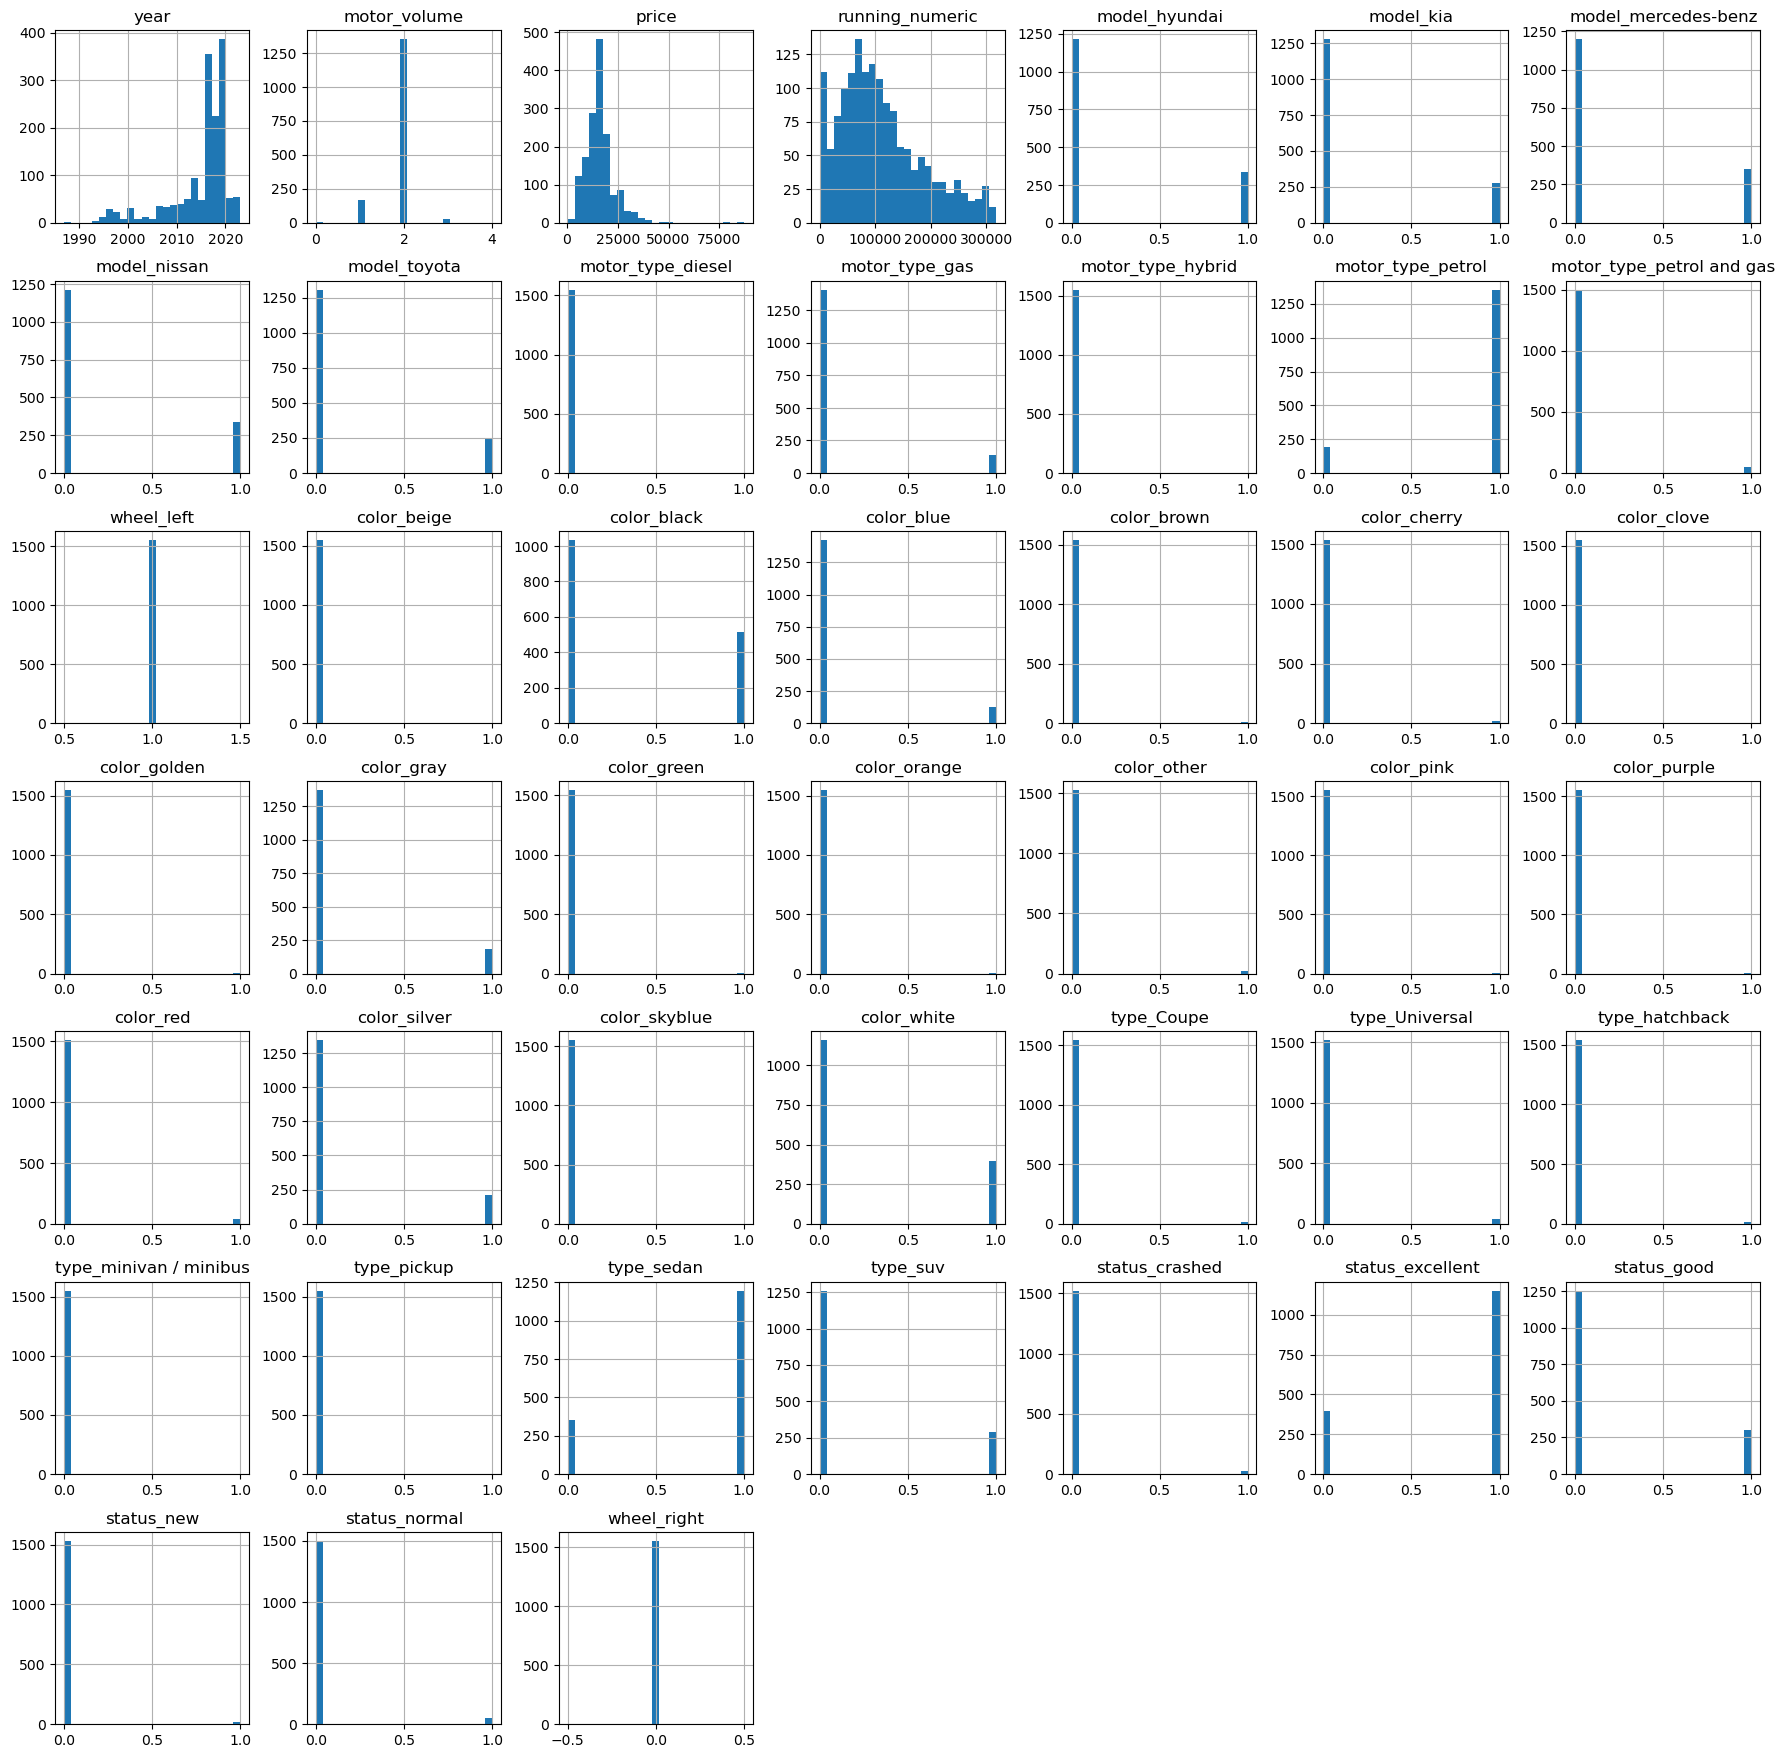

In [23]:
train_data.hist(figsize=(22,22), bins=25)

#### 2.6 Clean the test data by the same steps for future prediction analysis

In [24]:
test_data['running_numeric'] = test_data['running'].str.extract('(\d+)').astype(float)

In [25]:
test_data['running_numeric'] = test_data['running'].apply(convert_to_km)

In [26]:
test_data.drop('running',axis=1,inplace=True)

In [27]:
test_data['running_numeric'] = test_data['running_numeric'].astype('int64')
test_data['motor_volume'] = test_data['motor_volume'].astype('int64')

In [28]:
categorical_column2 = test_data.select_dtypes(include=['object']).columns.tolist()
numercial_column2 = test_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns = {(numercial_column2)}, \n\nCategorical columns = {(categorical_column2)}")

Numerical columns = ['year', 'motor_volume', 'running_numeric'], 

Categorical columns = ['model', 'motor_type', 'wheel', 'color', 'type', 'status']


In [29]:
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(test_data[categorical_column2])
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_column2))
test_data = test_data.drop(columns=categorical_column2)
test_data = pd.concat([test_data, encoded_features_df], axis=1)

/Users/jiaweizou/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [30]:
null_col3 = pd.DataFrame((test_data.isnull().sum()/test_data.shape[0])*100)
null_col3 = null_col3[null_col3[0]>0].reset_index().sort_values(by=0, ascending=False)
null_col3 = null_col3.rename(columns={0: "Percentage of NaN"})
null_col3['type'] = ["categorical" if x in categorical_column2 else "numeric" for x in null_col3['index']]

In [31]:
null_col3

,index,Percentage of NaN,type


In [32]:
test_data.isnull()

,year,motor_volume,running_numeric,model_hyundai,model_kia,model_mercedes-benz,model_nissan,model_toyota,motor_type_gas,motor_type_petrol,...,type_Coupe,type_Universal,type_hatchback,type_sedan,type_suv,status_crashed,status_excellent,status_good,status_new,status_normal
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
407,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
408,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
409,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 3. Fit Machine Learning models and select the most appropriate one

##### In this part, as there is no "price" value in the given test data, so my method is: I first randomly split the train data into train_inner data and test_inner data by 70% and 30% respectively. Second, use train_inner data to train different models, and use the trained models to predict "price" column of the test_inner data. And third, using MAE and RMSE of predicted "price" value and real "price" value in the test_inner data as criteria to make comparison between each model to select the most appropriate one. At last, train the most appropriate model selected by last step based on given train data to predict the "price" value in given test data. 

In [33]:
np.random.seed(100)
train_inner, test_inner = train_test_split(train_data, test_size = 0.3)

In [34]:
Train = train_inner.drop(columns = ['price']).values
Train_y = train_inner['price'].values
Test = test_inner.drop(columns = ['price']).values
Test_y = test_inner['price'].values

#### 3.1. OLS Regression

In [35]:
# Set up OLS regression model and fit the model by train data
OLS= LinearRegression()
OLS.fit(Train, Train_y)
OLS_predict = OLS.predict(Test)

In [36]:
# Get the R-squared scores to see the fitness of data to the model
OLS_train_score=OLS.score(Train, Train_y)
OLS_test_score=OLS.score(Test,Test_y)
print(f"OLS train score: {OLS_train_score}")
print(f"OLS test score: {OLS_test_score}")

OLS train score: 0.4420575299825814
OLS test score: 0.37440203086781665


In [37]:
# Get the MAE and RMSE values of models as criteria. 
MAE_OLS = mean_absolute_error(Test_y, OLS_predict)
rmse_OLS = np.sqrt(mean_squared_error(Test_y, OLS_predict))

In [38]:
print("The OLS MAE is:", MAE_OLS)
print("The RMSE is:", rmse_OLS)

The OLS MAE is: 3725.2894282647476
The RMSE is: 5677.129793807014


#### 3.2. LASSO Regression

In [39]:
# Set up LASSO regression model and fit the model by train data
LASSO = Lasso()
LASSO.fit(Train, Train_y)

Lasso()

In [40]:
A= [0.001,0.01, 0.1, 1.0, 10.0]
MSE_cleaned = []  
for a in A:
    LASSO = Lasso(alpha=a)
    scores = cross_val_score(LASSO, Train, Train_y, cv=4, scoring='neg_mean_squared_error')
    MSE_mean = -np.mean(scores)
    MSE_cleaned.append(MSE_mean)

/Users/jiaweizou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.219e+09, tolerance: 4.452e+06
  model = cd_fast.enet_coordinate_descent(
/Users/jiaweizou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.600e+08, tolerance: 4.089e+06
  model = cd_fast.enet_coordinate_descent(
/Users/jiaweizou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

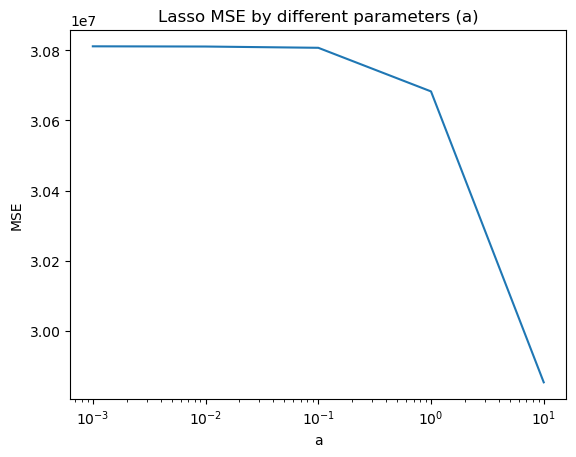

In [41]:
plt.plot(A, MSE_cleaned)
plt.xlabel('a')
plt.ylabel('MSE')
plt.title('Lasso MSE by different parameters (a)')
plt.xscale('log')  
plt.show()

In [42]:
# Select the best alpha to fit the model
Alpha_Best = A[np.argmin(MSE_cleaned)]  
print("The Best Alpha is",Alpha_Best)

The Best Alpha is 10.0


In [43]:
LASSO = Lasso(alpha=Alpha_Best)
LASSO.fit(Train, Train_y)
LASSO_predict = LASSO.predict(Test)

In [44]:
# Get the R-squared scores to see the fitness of data to the model
LASSO_train_score=LASSO.score(Train, Train_y)
LASSO_test_score=LASSO.score(Test,Test_y)
print(f"LASSO train score: {LASSO_train_score}")
print(f"LASSO test score: {LASSO_test_score}")

LASSO train score: 0.4358886943226954
LASSO test score: 0.3846773002019671


In [45]:
# Get the MAE and RMSE values of models as criteria. 
MAE_LASSO = mean_absolute_error(Test_y, LASSO_predict)
rmse_LASSO = np.sqrt(mean_squared_error(Test_y, LASSO_predict))

In [46]:
print("The Lasso MAE is:", MAE_LASSO)
print("The Lasso RMSE is:", rmse_LASSO)

The Lasso MAE is: 3684.6435339260033
The Lasso RMSE is: 5630.314140536109


#### 3.3 CART

In [47]:
# Set up CART regression model and fit the model by train data
CART_model = DecisionTreeClassifier()

In [48]:
parameter_grid = {
    'max_depth': [3, 4, 7, None],  
    'min_samples_split': [3, 7, 10], 
    'min_samples_leaf': [2, 4, 7],  
}
grid_search = GridSearchCV(CART_model, parameter_grid, cv=5, scoring='accuracy')

In [49]:
grid_search.fit(Train, Train_y)
print("Best parameter combination:", grid_search.best_params_)

/Users/jiaweizou/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameter combination: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 3}


In [50]:
# Fit the best CART model
CART_best = grid_search.best_estimator_
Test_y_predict_CART = CART_best.predict(Test)

In [51]:
# Get the MAE and RMSE values of models as criteria. 
MAE_CART = mean_absolute_error(Test_y, Test_y_predict_CART)
rmse_CART = np.sqrt(mean_squared_error(Test_y, Test_y_predict_CART))

In [52]:
print("The CART MAE is:", MAE_CART)
print("The CART RMSE is:", rmse_CART)

The CART MAE is: 3389.3304721030045
The CART RMSE is: 5574.576101207563


In [53]:
# Get the R-squared scores to see the fitness of data to the model
CART_train_score=CART_best.score(Train, Train_y)
CART_test_score=CART_best.score(Test,Test_y)
print(f"CART_best train score: {CART_train_score}")
print(f"CART_best test score: {CART_test_score}")

CART_best train score: 0.07649769585253456
CART_best test score: 0.030042918454935622


#### 3.4 Logistic Model

In [54]:
# Set up a Logistic model and fit the model by train data
logistic_model = LogisticRegression(fit_intercept=True, max_iter=1000).fit(Train,Train_y)
logistic_pred_test = logistic_model.predict(Test)

/Users/jiaweizou/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
# Get the MAE and RMSE values of models as criteria. 
MAE_logistic = mean_absolute_error(Test_y, logistic_pred_test)
rmse_logistic = np.sqrt(mean_squared_error(Test_y, logistic_pred_test))

In [56]:
print("The Random Forest MAE is:", MAE_logistic)
print("The Random Forest RMSE is:", rmse_logistic)

The Random Forest MAE is: 4135.93991416309
The Random Forest RMSE is: 6323.570305770085


In [57]:
# Get the R-squared scores to see the fitness of data to the model
Logistic_train_score=logistic_model.score(Train, Train_y)
Logistic_test_score=logistic_model.score(Test,Test_y)
print(f"Logistic train score: {Logistic_train_score}")
print(f"Logistic test score: {Logistic_test_score}")

Logistic train score: 0.04884792626728111
Logistic test score: 0.03862660944206009


#### 3.5 Random Forest

In [58]:
# Set up Random Forest model
rf_model = RandomForestRegressor(max_features=30, n_estimators=660, random_state=1)
rf_model.fit(Train, Train_y)

RandomForestRegressor(max_features=30, n_estimators=660, random_state=1)

In [59]:
pred_rf = rf_model.predict(Test)

In [60]:
# Get the MAE and RMSE values of models as criteria. 
MAE_rf = mean_absolute_error(Test_y, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(Test_y, pred_rf))

In [61]:
print("The Random Forest MAE is:", MAE_rf)
print("The Random Forest RMSE is:", rmse_rf)

The Random Forest MAE is: 3588.448959862265
The Random Forest RMSE is: 5724.511531635298


In [62]:
# Get the R-squared scores to see the fitness of data to the model
rf_train_score=rf_model.score(Train, Train_y)
rf_test_score=rf_model.score(Test,Test_y)
print(f"Random Forest model train score: {rf_train_score}")
print(f"Random Forest model test score: {rf_test_score}")

Random Forest model train score: 0.916681769679073
Random Forest model test score: 0.3639158814066271


#### 3.6 Boosting Model

In [63]:
# Set up Boosting model and fit the model by train data
boost_model = GradientBoostingRegressor(n_estimators=4000, learning_rate=0.01,random_state=1)
boost_model.fit(Train, Train_y)

GradientBoostingRegressor(learning_rate=0.01, n_estimators=4000, random_state=1)

In [64]:
pred_boost = boost_model.predict(Test)

In [65]:
# Get the MAE and RMSE values of models as criteria. 
MAE_bm = mean_absolute_error(Test_y, pred_boost)
rmse_boosting = np.sqrt(mean_squared_error(Test_y, pred_boost))

In [66]:
print("The Boosting Model MAE is:", MAE_bm)
print("The Boosting Model RMSE is:", rmse_boosting)

The Boosting Model MAE is: 3547.3580336007863
The Boosting Model RMSE is: 5827.796412199414


In [67]:
# Get the R-squared scores to see the fitness of data to the model
bm_train_score=boost_model.score(Train, Train_y)
bm_test_score=boost_model.score(Test,Test_y)
print(f"Boosting model train score: {bm_train_score}")
print(f"Boosting model test score: {bm_test_score}")

Boosting model train score: 0.79321691174947
Boosting model test score: 0.3407556341195701


#### 3.7 Neural Nets

In [68]:
# Set up Netual Net model and fit the model by train data
multi_layer_network = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=(Train.shape[1],)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

multi_layer_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
multi_layer_network.fit(Train, Train_y, epochs=25, batch_size=65, validation_split=0.1)

Epoch 1/25
16/16 [==============================] - 0s 4ms/step - loss: -675942592.0000 - accuracy: 0.0000e+00 - val_loss: -1369255040.0000 - val_accuracy: 0.0000e+00
Epoch 2/25
16/16 [==============================] - 0s 1ms/step - loss: -1875549312.0000 - accuracy: 0.0000e+00 - val_loss: -2868676608.0000 - val_accuracy: 0.0000e+00
Epoch 3/25
16/16 [==============================] - 0s 1ms/step - loss: -3605465600.0000 - accuracy: 0.0000e+00 - val_loss: -5240405504.0000 - val_accuracy: 0.0000e+00
Epoch 4/25
16/16 [==============================] - 0s 991us/step - loss: -6394009600.0000 - accuracy: 0.0000e+00 - val_loss: -9097597952.0000 - val_accuracy: 0.0000e+00
Epoch 5/25
16/16 [==============================] - 0s 1ms/step - loss: -10977244160.0000 - accuracy: 0.0000e+00 - val_loss: -15300344832.0000 - val_accuracy: 0.0000e+00
Epoch 6/25
16/16 [==============================] - 0s 989us/step - loss: -18041886720.0000 - accuracy: 0.0000e+00 - val_loss: -24450719744.0000 - val_accura

In [70]:
pred_nn = multi_layer_network.predict(Test)

15/15 [==============================] - 0s 332us/step


In [71]:
# Get the MAE and RMSE values of models as criteria. 
MAE_nn = mean_absolute_error(Test_y, pred_nn)
rmse_nn = np.sqrt(mean_squared_error(Test_y, pred_nn))

In [72]:
print("The Netual Nets MAE is:", MAE_nn)
print("The Netual Nets MSE is:", rmse_nn)

The Netual Nets MAE is: 15982.742489270386
The Netual Nets MSE is: 17520.45808580588


#### 3.8 Compare models and select the most appropriate one

In [73]:
MAE = pd.DataFrame({'Models': ["OLS Regression","Lasso Model", "CART Model", "Logistic Model","Random Forest", "Boosting Model", "Neural Nets"],
                     'MAE':[MAE_OLS,MAE_LASSO,MAE_CART, MAE_logistic, MAE_rf, MAE_bm, MAE_nn],
                    'RMSE':[rmse_OLS,rmse_LASSO,rmse_CART, rmse_logistic, rmse_rf, rmse_boosting, rmse_nn]})
MAE.sort_values(by=['MAE','RMSE'],ascending =False)

,Models,MAE,RMSE
6,Neural Nets,15982.742489,17520.458086
3,Logistic Model,4135.939914,6323.570306
0,OLS Regression,3725.289428,5677.129794
1,Lasso Model,3684.643534,5630.314141
4,Random Forest,3588.448960,5724.511532
5,Boosting Model,3547.358034,5827.796412
2,CART Model,3389.330472,5574.576101


In [74]:
R_Squared = pd.DataFrame({'Models': ["OLS Regression","Lasso Model", "CART Model", "Logistic Model","Random Forest", "Boosting Model"],
                     'R_Squared_train':[OLS_train_score,LASSO_train_score,CART_train_score,Logistic_train_score,rf_train_score,bm_train_score],
                      'R_Squared_test':[OLS_test_score,LASSO_test_score,CART_test_score,Logistic_test_score,rf_test_score,bm_test_score]})
R_Squared.sort_values(by=['R_Squared_train','R_Squared_test'],ascending =True)

,Models,R_Squared_train,R_Squared_test
3,Logistic Model,0.048848,0.038627
2,CART Model,0.076498,0.030043
1,Lasso Model,0.435889,0.384677
0,OLS Regression,0.442058,0.374402
5,Boosting Model,0.793217,0.340756
4,Random Forest,0.916682,0.363916


##### Here, it can be seen that CART Model has the least MAE and RMSE value between predicted "price" value and real "price" value in the test_inner data. However, the R-Squared_train value and R-Squared_test value of this model is very low. When I look back on the Random Forest model and Boosting Model, I find that the MAE and RMSE value of them are close, but Random Forest model has higher R-Squared_train value and R-Squared_test value. Therefore, choose Random Forest Model to predict the "price" in the given test data is the most appropriate. 

### 4. Make prediction for given test data by using the Random Forest model

In [75]:
test_data[['motor_type_diesel','motor_type_hybrid','color_golden','color_pink','color_purple','type_minivan / minibus','type_pickup','status_new','status_normal']]=0

In [76]:
# Set up the train data and test data
Train2 = train_data.drop(columns = ['price']).values
Train_y2 = train_data['price'].values
Test2 = test_data.values

In [77]:
rf_model = RandomForestRegressor(max_features=30, n_estimators=660, random_state=1)
rf_model.fit(Train2, Train_y2)

RandomForestRegressor(max_features=30, n_estimators=660, random_state=1)

In [78]:
pred_rf = rf_model.predict(Test2)

In [79]:
submission_test=pd.read_csv('test.csv')

In [80]:
submission= pd.DataFrame({'Id': submission_test.Id,'price': pred_rf})

In [81]:
submission

,Id,price
0,0,20273.257576
1,1,16962.348485
2,2,24998.578788
3,3,19356.590909
4,4,6429.446970
...,...,...
406,406,24288.272727
407,407,23312.954545
408,408,11652.651515
409,409,18084.909091


In [82]:
# Save the submission file
submission.to_csv('submission.csv',index=False)